# Lab9
In this laboratory, you will use a publicly available dataset. Public Domain Dedication datasets constitute an extremely valuable asset for the data science community. 

This public dataset is part of Airbnb, and the original source can be found on Inside [Airbnb](http://insideairbnb.com/).
Each row of the dataset corresponds to an Airbnb listing in New York City, for the year 2019. As for the previous competition, the dataset has been divided in a Development set and an Evaluation one.

Each file has an initial header line, containing the names of attributes at your disposal:
- id: a unique identifier of the listing
- name
- host_id: a unique identifier of the host
- host_name
- neighborhood_group: neighborhood location in the city
- neighborhood: name of the neighborhood
- latitude: coordinate expressed as floating point number
- longitude: coordinate expressed as floating point number
- room_type
- price: price per night expressed in dollars
- minimum_nights: minimum nights requested by the host
- number_of_reviews
- last_review: date of the last review expressed as YYYY-MM-DD
- reviews_per_month: average number of reviews per month
- calculated_host_listings_count: amount of listing of the host
- availability_365: number of days when the listing is available for booking You can download the dataset at:

https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_Airbnb.zip

The data have been distributed uniformly in two separate collections. Each collection is in a different file. The dataset archive is organized as follows:
- development.csv (Development set): a collection of listings with the price column. This collection of data has to be used during the development of the regression model.
- evaluation.csv (Evaluation set): a collection of listings without the price column. This collection of data has to be used to produce the submission file.
- sample_submission.csv: a sample submission file.

So far, you should be used to work, while developing your models, with training, validation and test sets. In this case, the Development data must be used to tune your hyper-parameters while you should consider the Evaluation portion as the actual test set.

## Exercise description
In this exercise, you will try to predict the price of an Airbnb listing in NYC, published in 2019, using several contextual information. To do so, your primary goal will be modeling, through a regression-based pipeline, the relationship between information on the listing (e.g. its geographical location, the reviews it received, or many other metrics you might figure out) and the price itself.
Once your model is complete, you will predict, for a set of listings whose price is unknown, how much would it cost to you spending one night at them.
Finally, you will be able to upload your regression results and participate to the lab competition.

### Exercise 2.1.1
Load the dataset from the root folder

In [1]:
!test -e NYC_Airbnb.zip || wget "https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_Airbnb.zip" -O NYC_Airbnb.zip
!test -e NYC_Airbnb/development.csv || unzip NYC_Airbnb.zip
!du ./NYC_Airbnb/*

11344	./NYC_Airbnb/development.csv
2776	./NYC_Airbnb/evaluation.csv
248	./NYC_Airbnb/sample_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_dev = pd.read_csv("NYC_Airbnb/development.csv", index_col=0)
df_eval = pd.read_csv("NYC_Airbnb/evaluation.csv", index_col=0)
df_dev.shape, df_eval.shape

((39116, 15), (9779, 14))

In [4]:
# Understanding the data
df_dev.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351
3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263
17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,NaN,1,0
33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89
9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103


In [5]:
df_dev.info()
df_dev.columns

<class 'pandas.core.frame.DataFrame'>
Index: 39116 entries, 12783632 to 15310580
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            39103 non-null  object 
 1   host_id                         39116 non-null  int64  
 2   host_name                       39097 non-null  object 
 3   neighbourhood_group             39116 non-null  object 
 4   neighbourhood                   39116 non-null  object 
 5   latitude                        39116 non-null  float64
 6   longitude                       39116 non-null  float64
 7   room_type                       39116 non-null  object 
 8   price                           39116 non-null  int64  
 9   minimum_nights                  39116 non-null  int64  
 10  number_of_reviews               39116 non-null  int64  
 11  last_review                     31075 non-null  object 
 12  reviews_per_month          

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [6]:
for col in ["room_type", "neighbourhood_group", "neighbourhood"]:
    print(col, df_dev[col].unique())

room_type ['Private room' 'Entire home/apt' 'Shared room']
neighbourhood_group ['Queens' 'Manhattan' 'Brooklyn' 'Bronx' 'Staten Island']
neighbourhood ['Elmhurst' 'Upper East Side' 'Bushwick' 'Fort Greene' 'Greenwich Village'
 'Washington Heights' 'Boerum Hill' 'Morrisania' 'Williamsburg'
 'Greenpoint' 'University Heights' 'East Village' 'Bedford-Stuyvesant'
 'East Harlem' "Hell's Kitchen" 'East Flatbush' 'Park Slope'
 'Richmond Hill' 'Upper West Side' 'Murray Hill' 'Lower East Side'
 'Chinatown' 'Prospect-Lefferts Gardens' 'Prospect Heights' 'Flushing'
 'Midtown' 'Clinton Hill' 'Ditmars Steinway' 'Harlem' 'Financial District'
 'Crown Heights' 'Ridgewood' 'Gramercy' 'Nolita' 'Inwood'
 'Claremont Village' 'Astoria' 'Civic Center' 'West Village' 'Sunnyside'
 'Gowanus' 'Cambria Heights' 'South Slope' 'Long Island City'
 'Hunts Point' 'Morningside Heights' 'Sheepshead Bay' 'Red Hook' 'Chelsea'
 'East Elmhurst' 'Port Morris' 'Jackson Heights' 'DUMBO' 'Flatbush'
 'Gravesend' 'Two Bridges' 'K

### Exercise 2.1.2
Focus now on the data preparation step. You should have noticed that the attributes that describe each listing are heterogeneous, both on the source (e.g. geographical, related to host, related to Airbnb, etc.) and on the type (e.g. numerical, categorical, date, etc.). Before continuing, take you your time to answer these questions:
- which attribute (or set of attributes) you think could drive the price per night the most?
- can you detect any irregularity in any attribute distribution?
- if your regression model will fit on numerical data only, how could you handle categorical attributes?
Transform your initial dataset following the ideas you draw out.


#### Exercise 2.1.2 ansers
- which attribute (or set of attributes) you think could drive the price per night the most?
    - I think that the attributes that could drive the price per night the most are the following:
        - room_type
        - neighborhood_group
        - neighborhood
        - latitude
        - longitude
        - number_of_reviews
        - reviews_per_month
- can you detect any irregularity in any attribute distribution?
    - Yes, I can detect irregularities in the following attributes:
        - name: is missing in some rows, and this is strange because it is a very important attribute
        - some other fields are missing in some rows, but this is not a problem because they are not so important
        - rewiews_per_month: is missing in some rows. If null it will be replaced with 0
- if your regression model will fit on numerical data only, how could you handle categorical attributes?
    - It is better to transform some fileds in numerical values -> I will use the OneHotEncoder to transform these fields in numerical values. 
    These fields are:
        - room_type
        - neighborhood_group
        - neighborhood
        

### Implementing the pipeline

In [7]:
# Merging datasets before ore-processing to make sure we have the same features (particularity for one hot encoding)
df = pd.concat([df_dev, df_eval], sort=False)
len(df_dev), len(df_eval), len(df)

(39116, 9779, 48895)

In [8]:
df["reviews_per_month"].fillna(0, inplace=True) # with inplace, we make the changes directly to df

In [9]:
# Applying one-hot encoding
# columns_to_encode = ["neighbourhood_group", "neighbourhood", "room_type"]  # r2=0.10477908183058071
# columns_to_encode = ["room_type"]  # r2=0.10477908183058071
columns_to_encode = ["room_type", "neighbourhood_group"]  # r2=0.14904312905047823

df_1h = pd.get_dummies(df, columns=columns_to_encode)
df_1h.head()

df_1h.shape

(48895, 21)

In [10]:
# Now we have a lot of columns. 'neighbourhood_group', 'neighbourhood', 'room_type' are now one-hot encoded.
df_1h.info()
df_1h.shape

<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 12783632 to 36485057
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   name                               48879 non-null  object 
 1   host_id                            48895 non-null  int64  
 2   host_name                          48874 non-null  object 
 3   neighbourhood                      48895 non-null  object 
 4   latitude                           48895 non-null  float64
 5   longitude                          48895 non-null  float64
 6   price                              39116 non-null  float64
 7   minimum_nights                     48895 non-null  int64  
 8   number_of_reviews                  48895 non-null  int64  
 9   last_review                        38843 non-null  object 
 10  reviews_per_month                  48895 non-null  float64
 11  calculated_host_listings_count     48895 non-null

(48895, 21)

By applying the 1-hot encoding, we are converting our original 15 columns into 241. This is because we have 221 possible values for neighbourhood, 5 for neighbourhood_group and 3 for room_type, but we are removing the three original columns

#### Trying also to conside "name" with tokenizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", binary=True, use_idf=False, norm='l2')
wpm = vectorizer.fit_transform(df_1h["name"].fillna(""))

In [12]:
# Finding the most N frequent words
freq_N = 150
freq = sorted(zip(vectorizer.get_feature_names_out(), wpm.sum(axis=0).tolist()[0]), key=lambda x: x[1], reverse=True)[:freq_N]

freq[:15]

[('room', 4693.217841236685),
 ('bedroom', 3845.5284920079835),
 ('private', 3244.4331786069506),
 ('apartment', 3223.681631837905),
 ('cozy', 2348.424480585623),
 ('apt', 2051.2535296782125),
 ('brooklyn', 2022.4043334282153),
 ('studio', 1918.1549886847215),
 ('spacious', 1740.07366711978),
 ('manhattan', 1623.3713169546334),
 ('east', 1395.9055833486213),
 ('park', 1359.0982562416607),
 ('sunny', 1338.0475806412985),
 ('williamsburg', 1337.3812122416907),
 ('beautiful', 1173.5166326198896)]

In [13]:
# mask to be used to filter columns in wpm (only keeps the ones for the 100 most frequent words)
words = [ word for word, _ in freq ]
mask = [ w in words for w in vectorizer.get_feature_names_out() ]
words_ = [ w for w in vectorizer.get_feature_names_out() if w in words ] 
words_df = pd.DataFrame(data=wpm[:, np.array(mask)].toarray(), columns=[f"word_{word}" for word in words_], index=df_1h.index)

#### Preparing the data

In [14]:
# columns_to_drop = ["host_id", "name", "host_name", "last_review"]  # r2=0.07128877883880957
columns_to_drop = ["name", "host_name", "last_review", "neighbourhood"]  # r2=0.14904312905047823
df_dropped = df_1h.drop(columns=columns_to_drop)  # dropping useless columns

df_dropped = df_dropped.join(words_df)  # r2_150word=0.1802783800201918

df_dropped.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,room_type_Entire home/apt,...,word_ues,word_upper,word_uws,word_view,word_views,word_village,word_walk,word_west,word_williamsburg,word_york
id,,,,,,,,,,,,,,,,,,,,,
12783632,57230304,40.74037,-73.88610,75.0,1,2,0.92,3,351,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3463385,10698270,40.76717,-73.95532,95.0,1,202,3.31,2,263,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17572926,36578169,40.77984,-73.94725,130.0,2,0,0.00,1,0,True,...,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33913644,50981314,40.70205,-73.91338,150.0,2,4,1.64,1,89,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9405895,48775347,40.68914,-73.97853,325.0,3,16,0.42,1,103,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
feature_names = df_dropped.drop(columns=["price"]).columns
feature_names

train_valid_mask = ~df_dropped["price"].isna()  # value is True for the training set and False for the test set

# Splitting the dataset into dev and eval (after the analysis)
X = df_dropped.drop(columns=["price"]).values
y = df_dropped["price"].values

# Splitting the dev dataset into train and test
X_dev = X[train_valid_mask]
y_dev = y[train_valid_mask]
X_eval = X[~train_valid_mask]
y_eval = y[~train_valid_mask]

X_dev.shape, y_dev.shape, X_eval.shape, y_eval.shape

((39116, 166), (39116,), (9779, 166), (9779,))

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_dev, y_dev, test_size=0.25, shuffle=True, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((29337, 166), (9779, 166), (29337,), (9779,))

#### Exercise 2.1.3
Once you have your final dataset representation, choose one regression model of those you know. Then, perform the classic training-validation pipeline on the Development dataset to identify the best set of hyper-parameters for your model. As you can read in Section 3.3, we will evaluate your results on the MSE score (Mean Squared Error). Hence, it is a reasonable option trying to optimize it on the Development set.

In [17]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(300, max_features="log2", random_state=42)  # 100 during testing and 300 for submission
print("Fitting the model...")
reg.fit(X_train , y_train)

Fitting the model...


RandomForestRegressor(max_features='log2', n_estimators=300, random_state=42)

In [18]:
from sklearn.metrics import r2_score, mean_squared_error

print("Calculating the score...")
r2 = r2_score(y_valid, reg.predict(X_valid))
mse = mean_squared_error(y_valid, reg.predict(X_valid))
print(f"R2 score: {r2}")
print(f"MSE: {mse}")

Calculating the score...
R2 score: 0.23769389876395586
MSE: 41760.849704833214


In [19]:
reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [20]:
sorted(zip(feature_names, reg.feature_importances_), key=lambda x: x[1], reverse=True)

[('longitude', 0.10068635021773224),
 ('latitude', 0.0838591703913738),
 ('host_id', 0.07855495804721765),
 ('minimum_nights', 0.06578087529649966),
 ('availability_365', 0.06255362672036564),
 ('reviews_per_month', 0.04506638789464297),
 ('number_of_reviews', 0.03732066535546345),
 ('calculated_host_listings_count', 0.02866740180523807),
 ('room_type_Entire home/apt', 0.024698900998533505),
 ('room_type_Private room', 0.02418294045821683),
 ('word_location', 0.015536087293095842),
 ('word_luxury', 0.01410630440907999),
 ('word_room', 0.014040788950999418),
 ('word_apt', 0.013687912195444615),
 ('word_townhouse', 0.013405871136687087),
 ('word_east', 0.013283406063808708),
 ('word_center', 0.012615622029119011),
 ('word_br', 0.011881194499180594),
 ('neighbourhood_group_Manhattan', 0.011621107168246771),
 ('word_apartment', 0.011552269379865407),
 ('word_furnished', 0.010864672304364486),
 ('word_bedroom', 0.009964234130629092),
 ('word_nyc', 0.008922460084808083),
 ('word_harlem', 0.0

#### Finding the best regression model
Like in the lab8, I'm trying to find the best regression model

### Exercise 2.1.4
Assign a price value to each listing in the Evaluation set.

In [21]:
predictions = reg.predict(X_eval)

In [22]:
predictions

array([130.12333333, 140.71333333,  97.43666667, ..., 105.13      ,
       119.45666667,  64.02333333])

In [23]:
# predictions = np.round(predictions, 0)
# np.round(predictions, 2)

In [24]:
pd.DataFrame(predictions, index=df[~train_valid_mask].index).to_csv("output_vellons.csv", index_label="Id", header=["Predicted"])

### Exercise 2.1.5
Define a function to generate a 2D scatterplot with the prices. The chart must be drawn as heatmap: use the latitude and longitude coordinates along the axes and the price value to assign a color to the point. Then, apply the function to the prices from the Development set and to the ones you predicted for the Evaluation set. 

From Section 1.1, you know that Development and Evaluation were generated with a uniform sampling on the initial listings. So, what should you expect on the map, if your regression were correct?


In [25]:
# From lab5

class CellConverter:
    def __init__(self, df, n_splits):
        self.lat_min = df["latitude"].min()
        self.lat_max = df["latitude"].max()
        self.long_min = df["longitude"].min()
        self.long_max = df["longitude"].max()
        self.n_splits = n_splits
    
    def plot_grid(self, ax):
        lat_steps = np.linspace(self.lat_min, self.lat_max, self.n_splits + 1)
        long_steps = np.linspace(self.long_min, self.long_max, self.n_splits + 1)
        ax.hlines(lat_steps, self.long_min, self.long_max)
        ax.vlines(long_steps, self.lat_min, self.lat_max)
    
    def point_to_cell_coord(self, long, lat):
        x = int((long - self.long_min)/(self.long_max - self.long_min)*self.n_splits)
        y = int((lat - self.lat_min)/(self.lat_max - self.lat_min)*self.n_splits)
        return x, y
    
    def point_to_cell_id(self, long, lat):
        x, y = self.point_to_cell_coord(long, lat)
        return y * n_splits + x
    
    def calculate_average_prices(self, pois_df):
        avg_prices = np.zeros((self.n_splits, self.n_splits))

        for cell_id in range(self.n_splits * self.n_splits):
            points_in_cell = pois_df[pois_df["cell_id"] == cell_id]
            avg_price = points_in_cell["price"].mean()
            x, y = divmod(cell_id, self.n_splits)
            avg_prices[x][y] = avg_price
            
        return avg_prices
    
    def calculate_max_prices(self, pois_df):
        max_prices = np.zeros((self.n_splits, self.n_splits))

        for cell_id in range(self.n_splits * self.n_splits):
            points_in_cell = pois_df[pois_df['cell_id'] == cell_id]
            max_price = points_in_cell['price'].max()
            x, y = divmod(cell_id, self.n_splits)
            max_prices[x][y] = max_price

        return max_prices

n_splits = 20
cell_conv = CellConverter(df_dev, n_splits)

df_dev['cell_id'] = df_dev.apply(lambda x: cell_conv.point_to_cell_id(x['longitude'], x['latitude']), axis=1)
df_dev.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,cell_id
id,,,,,,,,,,,,,,,,
12783632,NYC Mini Hotel,57230304,Imanuelly,Queens,Elmhurst,40.74037,-73.88610,Private room,75,1,2,2019-05-26,0.92,3,351,233
3463385,Gorgeous room in Manhattan,10698270,Evgenia,Manhattan,Upper East Side,40.76717,-73.95532,Private room,95,1,202,2019-05-27,3.31,2,263,250
17572926,Great 1 Bedroom on Upper East,36578169,James,Manhattan,Upper East Side,40.77984,-73.94725,Entire home/apt,130,2,0,NaN,NaN,1,0,271
33913644,"Modern and bright 2Bed 2Bath Bushwick, Brooklyn",50981314,Ofier,Brooklyn,Bushwick,40.70205,-73.91338,Entire home/apt,150,2,4,2019-07-07,1.64,1,89,192
9405895,Stylish and zen Brooklyn retreat,48775347,Mathieu,Brooklyn,Fort Greene,40.68914,-73.97853,Entire home/apt,325,3,16,2019-04-20,0.42,1,103,170


In [26]:
# From lab5
from matplotlib import colormaps


class Map:
    def __init__(self, df):
        """Store Dataset with POIs information."""
        self.pois_df = df
        self.lat_min = df['latitude'].min()
        self.lat_max = df['latitude'].max()
        self.long_min = df['longitude'].min()
        self.long_max = df['longitude'].max()
        
    def plot_map(self):
        """Display an image with NY map and return the Axes object."""
        fig, ax = plt.subplots(figsize=(10, 8))
        nyc_img = plt.imread('./New_York_City_Map.PNG')
        ax.imshow(nyc_img, zorder=0, extent=[self.long_min,
            self.long_max, self.lat_min, self.lat_max])
        ax.grid(False)
        return ax
        
    def plot_pois(self, ax, category, mask):
        """Plot data on specified Axis."""
        df = self.pois_df.loc[mask]
        
        types = df[category].unique()
        cmap = colormaps.get_cmap('viridis').reversed()  # Using get_cmap to retrieve the colormap object
        norm = plt.Normalize(df["price"].min(), df["price"].max())  # Normalizing price values

        for i, t in enumerate(types):
            df_t = df.loc[df[category] == t]
            colors = cmap(norm(df_t["price"]))  # Map prices to colors using the colormap
            df_t.plot.scatter(
                x='longitude',
                y='latitude',
                ax=ax,
                c=colors,
                alpha=0.5,
                label=None,  # No label for the scatter plot points
            )

        # Creating a color bar representing the price range
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Empty array
        plt.colorbar(sm, ax=ax, label='Price Range')  # Creating the color bar

        ax.grid(False)
        ax.set_title(f"NY Airbnb price")
        return ax

    def plot_heatmap_with_average_prices(self, ax, cell_conv):
        prices = cell_conv.calculate_average_prices(self.pois_df)
        #prices = cell_conv.calculate_max_prices(self.pois_df)

        cmap = colormaps.get_cmap('viridis').reversed()
        im = ax.imshow(prices[::-1], cmap=cmap, alpha=0.6, interpolation='nearest', extent=[self.long_min, self.long_max, self.lat_min, self.lat_max])

        plt.colorbar(im, label='Average Price')  # Adding colorbar with average price scale
        ax.set_xlabel('longitude')
        ax.set_ylabel('latitude')
        ax.set_title('NY average price heatmapp')

        ax.grid(False)
        plt.show()

ny_map = Map(df_dev)

<Axes: title={'center': 'NY Airbnb price'}, xlabel='longitude', ylabel='latitude'>

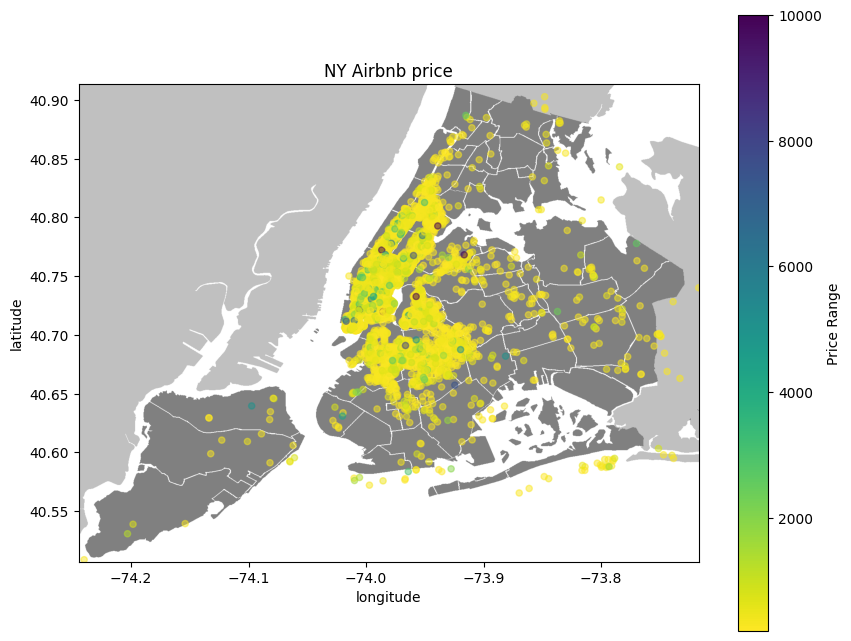

In [27]:
ax = ny_map.plot_map()
mask = df_dev["price"] > 200
ny_map.plot_pois(ax, "price", mask)

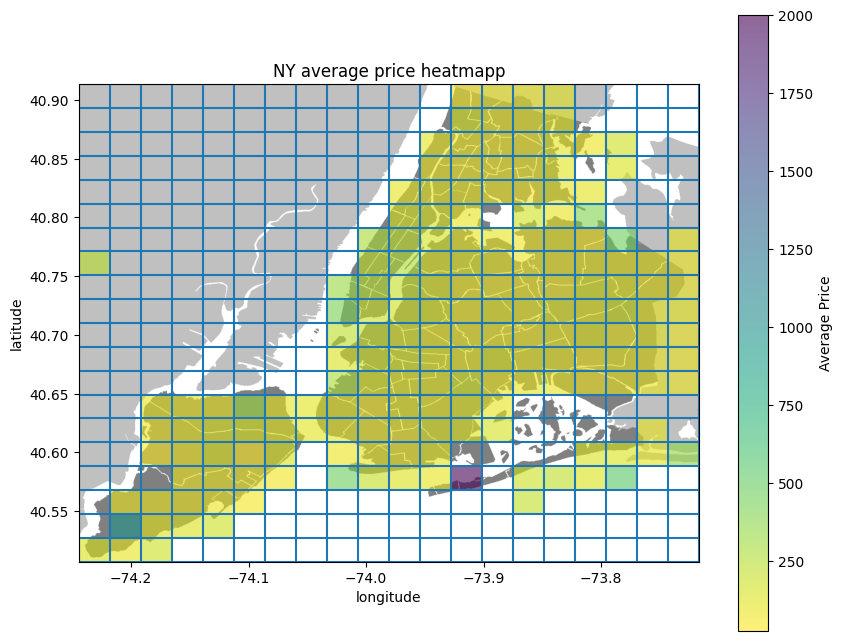

In [28]:
ax2 = ny_map.plot_map()
cell_conv.plot_grid(ax2)
ny_map.plot_heatmap_with_average_prices(ax2, cell_conv)

In [29]:
# Now map of predictions
cell_conv_eval = CellConverter(df_eval, n_splits)

df_eval["price"] = predictions
df_eval['cell_id'] = df_eval.apply(lambda x: cell_conv.point_to_cell_id(x['longitude'], x['latitude']), axis=1)
df_eval.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,price,cell_id
id,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,2018-10-19,0.21,6,365,130.123333,130
5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,45,49,2017-10-05,0.40,1,0,140.713333,170
5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,2,118,2017-07-21,0.99,1,0,97.436667,290
5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,1,160,2019-06-09,1.33,4,188,210.060000,209
6848,Only 2 stops to Manhattan studio,15991,Allen & Irina,Brooklyn,Williamsburg,40.70837,-73.95352,Entire home/apt,2,148,2019-06-29,1.20,1,46,156.880000,191


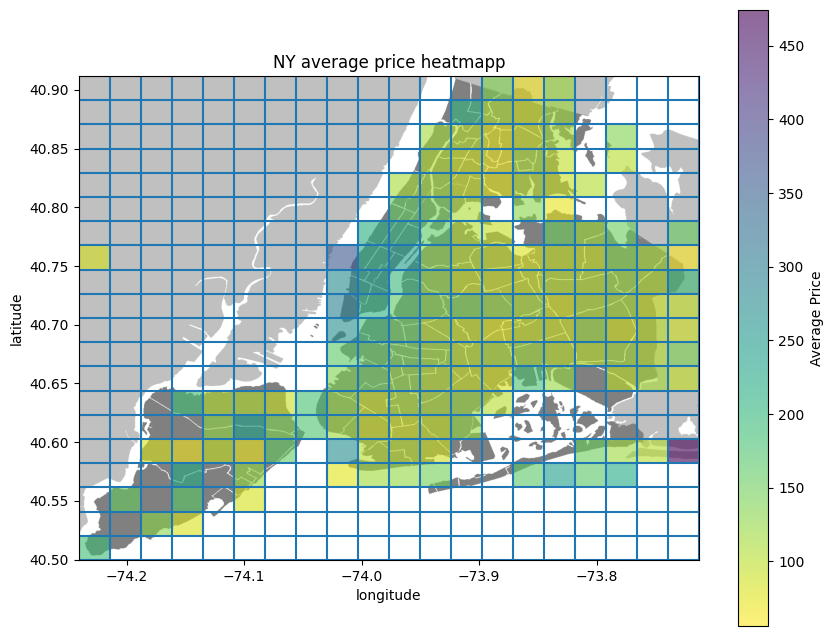

In [30]:
ny_eval_map = Map(df_eval)
ax3 = ny_eval_map.plot_map()
cell_conv_eval.plot_grid(ax3)
ny_eval_map.plot_heatmap_with_average_prices(ax3, cell_conv_eval)